<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/BP_2004__T4_GPU_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 11.3 MB/s eta 0:00:00


In [1]:
!pip install deepwave

Using device: cuda
Grid: 1349x478 | dx=50.0m | Shots=20

--- STAGE 1: 3.0 Hz ---
Epoch 5/30 | Loss: 1.968140
Epoch 10/30 | Loss: 1.344547
Epoch 15/30 | Loss: 1.136591
Epoch 20/30 | Loss: 0.953027
Epoch 25/30 | Loss: 0.840221
Epoch 30/30 | Loss: 0.767142

--- STAGE 2: 6.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 6.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 50.0, there are only 4.76.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 6.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 50.0, there are only 4.83.
  warnings.warn(


Epoch 5/30 | Loss: 0.916557
Epoch 10/30 | Loss: 0.751232
Epoch 15/30 | Loss: 0.681181
Epoch 20/30 | Loss: 0.633592
Epoch 25/30 | Loss: 0.606906
Epoch 30/30 | Loss: 0.587340


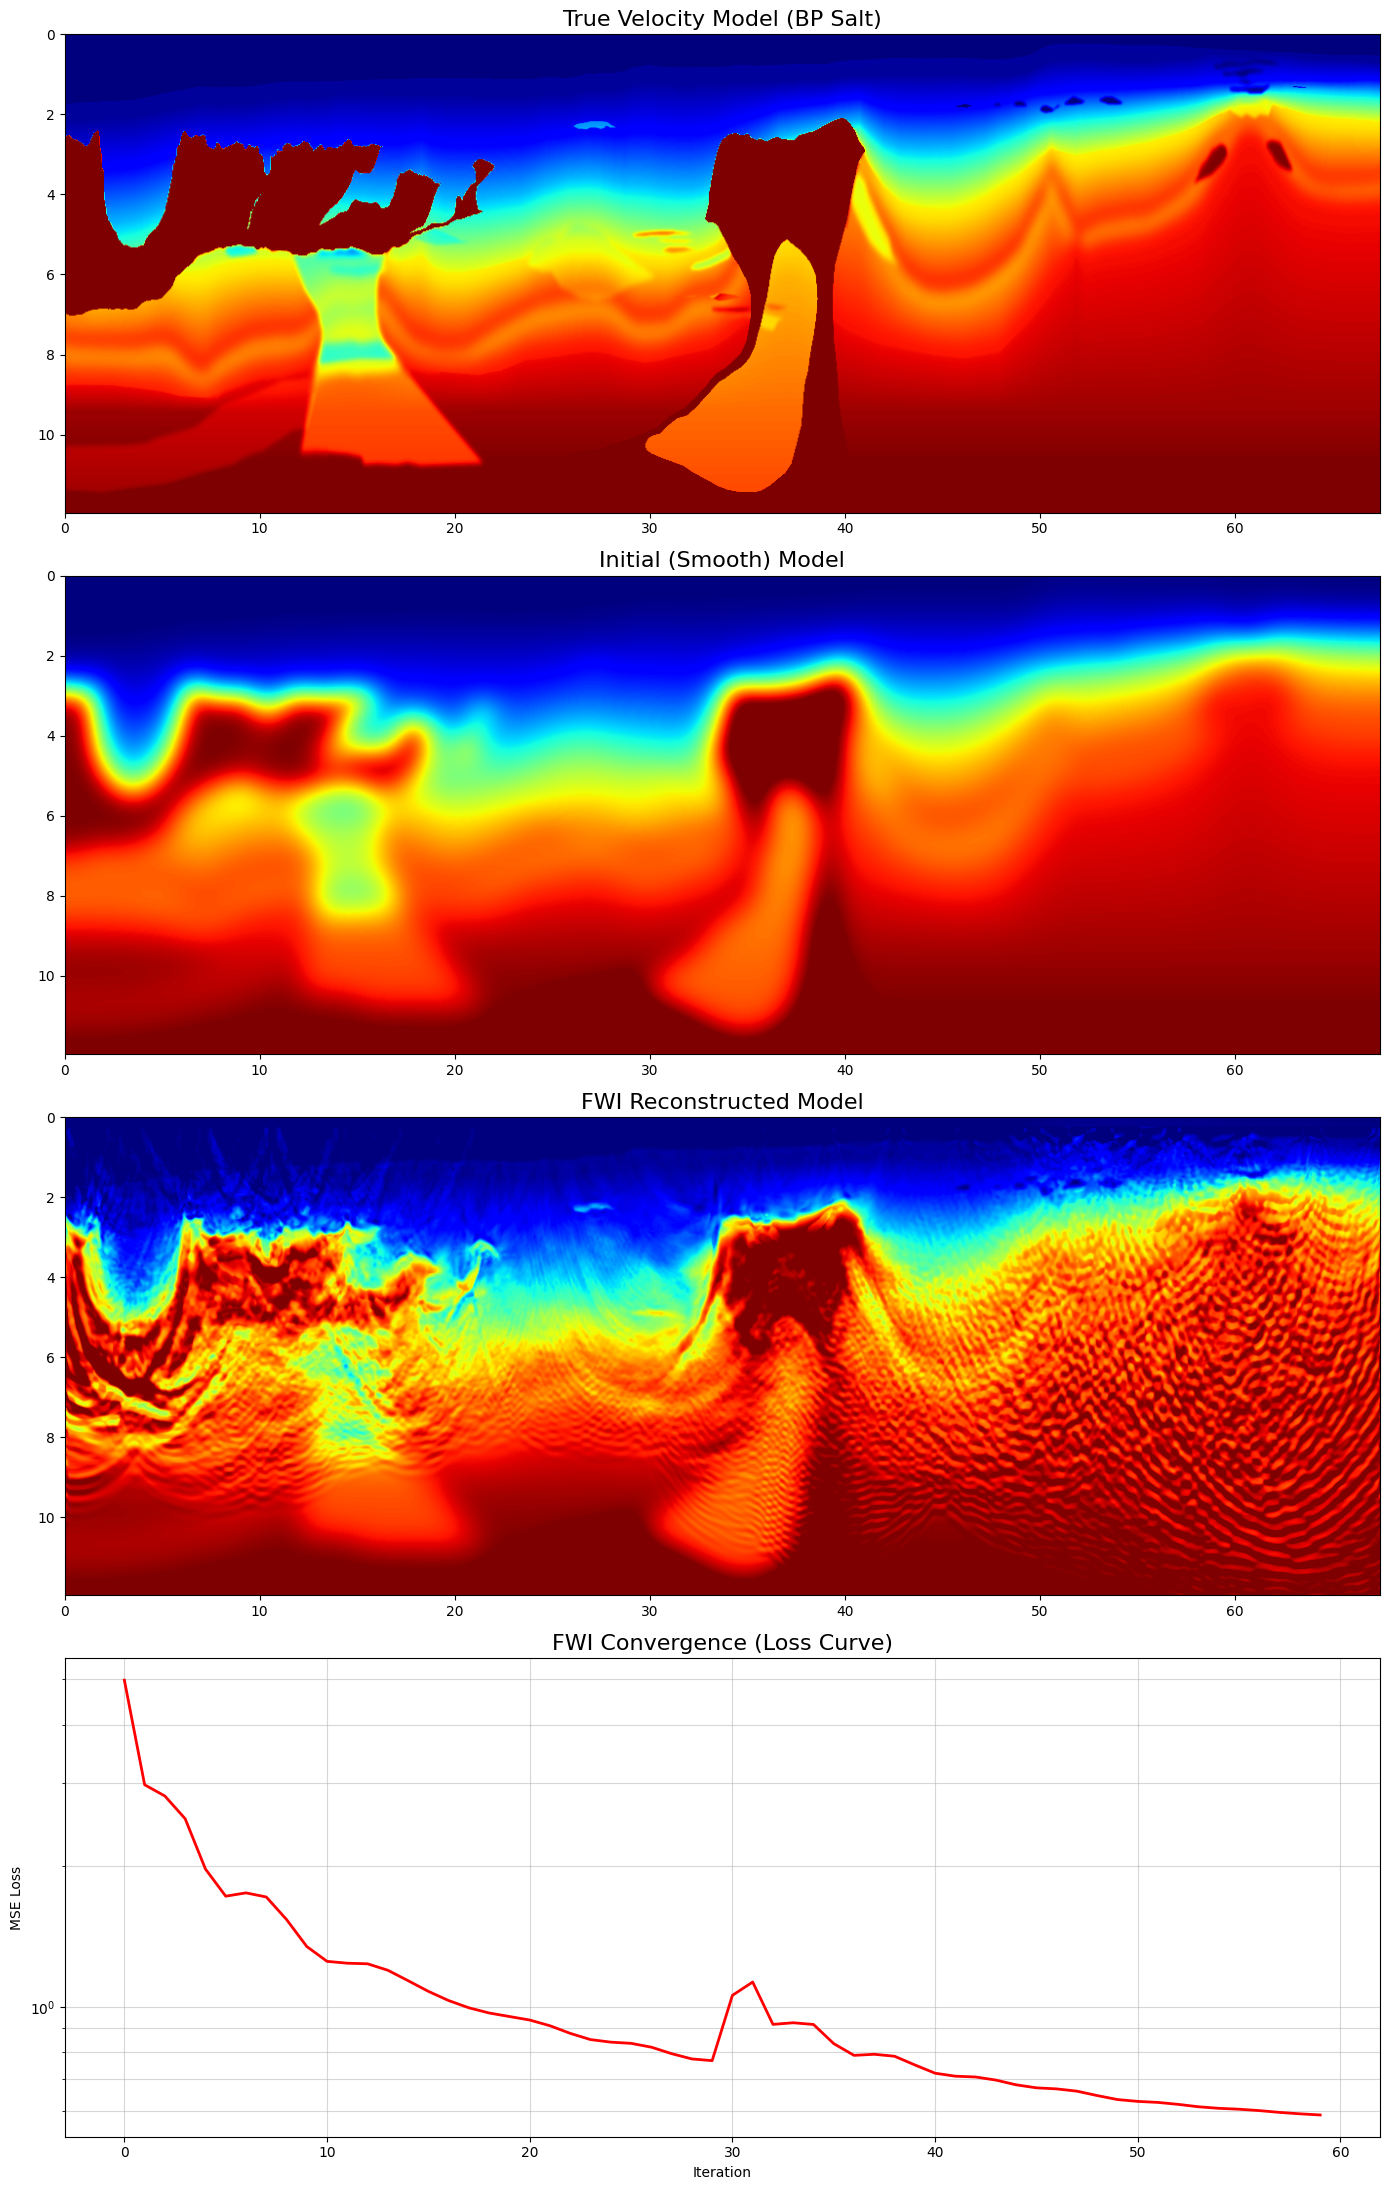

In [3]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- MEMORY MANAGEMENT ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- GPU GAUSSIAN SMOOTHING ---
def gaussian_blur_2d(img, sigma):
    if sigma <= 0: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL PARAMETERS ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Generating synthetic model for testing...")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
    vp_cpu[:, 800:] = 3500.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 4 downsampling (Fits well on T4 GPU)
factor = 4.0
vp_np = vp_cpu.numpy()
vp_reduced = gaussian_filter(vp_np, sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=15)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION PARAMETERS ---
n_shots = 20
batch_size = 4
n_receivers_per_shot = 300
nt = 1800
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(400 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 30.0 * z_grad**2).repeat(nx, 1)

# --- INVERSION SETUP ---
freqs = [3.0, 6.0]
epochs_per_stage = 30
lrs = [20.0, 12.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx}m | Shots={n_shots}")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # 1. GENERATE OBSERVED DATA (Fixed Warnings here)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:i+batch_size],
                         source_locations=source_loc[i:i+batch_size],
                         receiver_locations=receiver_loc[i:i+batch_size],
                         pml_freq=freq, # <--- FIX: Added pml_freq
                         pml_width=[30, 30, 30, 30])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    # 2. INVERSION LOOP
    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        # Shuffle shots for stochastic gradient descent
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:i+batch_size]

            # Forward pass (Fixed Warnings here)
            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, # <--- FIX: Added pml_freq
                              pml_width=[30, 30, 30, 30],
                              model_gradient_sampling_interval=8)

            loss = F.mse_loss(out_pred[-1], obs_data[indices])
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Pre-conditioning
        with torch.no_grad():
            v1.grad *= (mask * depth_weight)
            # Smooth gradient to prevent high-freq artifacts
            v1.grad.copy_(gaussian_blur_2d(v1.grad, sigma=1.5))

        optimizer.step()
        v1.data.clamp_(min=1450.0, max=4800.0)

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage} | Loss: {avg_loss:.6f}")

# --- VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(14, 22))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4500}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=16)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial (Smooth) Model", fontsize=16)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("FWI Reconstructed Model", fontsize=16)

ax[3].plot(history, color='red', lw=2)
ax[3].set_title("FWI Convergence (Loss Curve)", fontsize=16)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("MSE Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/25 | Scaled Loss: 0.130780
Epoch 10/25 | Scaled Loss: 0.106042
Epoch 15/25 | Scaled Loss: 0.088029
Epoch 20/25 | Scaled Loss: 0.076944
Epoch 25/25 | Scaled Loss: 0.067454

--- STAGE 2: 5.0 Hz ---
Epoch 5/25 | Scaled Loss: 0.150312
Epoch 10/25 | Scaled Loss: 0.120308
Epoch 15/25 | Scaled Loss: 0.116138
Epoch 20/25 | Scaled Loss: 0.109425
Epoch 25/25 | Scaled Loss: 0.112280

--- STAGE 3: 7.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.44.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1449.999755859375, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(


Epoch 5/25 | Scaled Loss: 0.169086
Epoch 10/25 | Scaled Loss: 0.166627
Epoch 15/25 | Scaled Loss: 0.169710
Epoch 20/25 | Scaled Loss: 0.154536
Epoch 25/25 | Scaled Loss: 0.146820


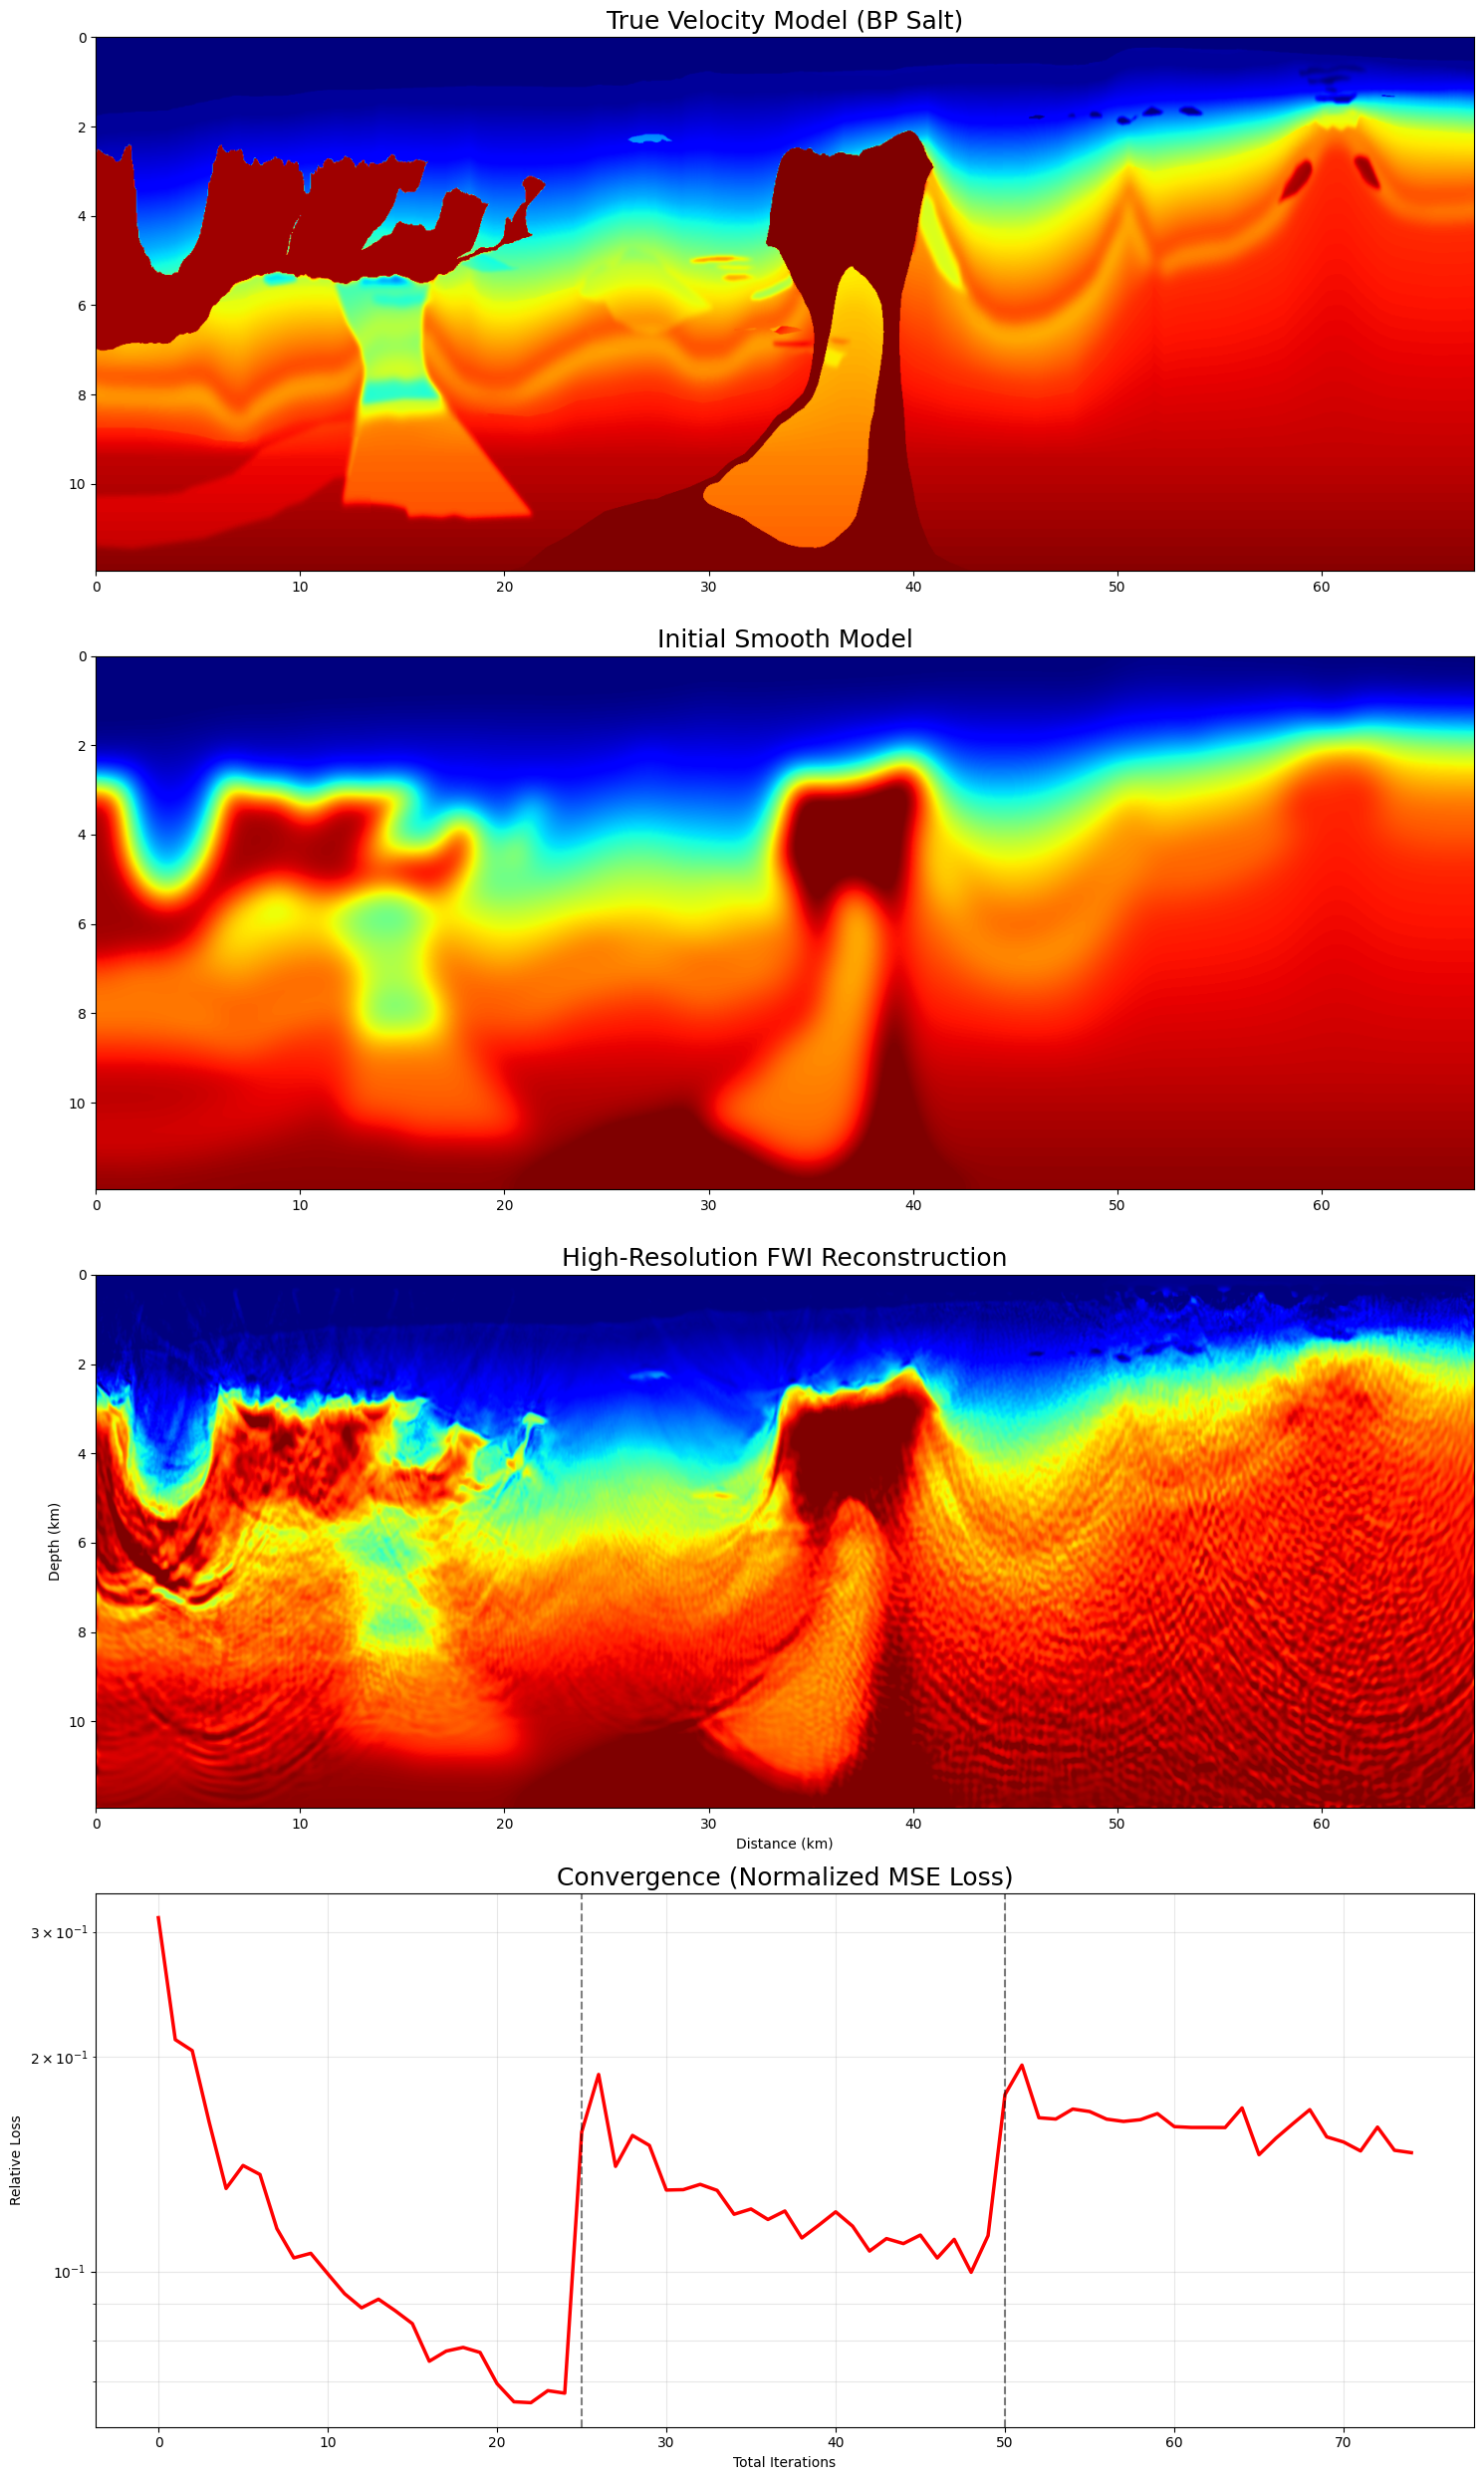

In [4]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = 25
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            # This allows the model to capture details while keeping salt solid
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=i*epochs_per_stage, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### More iterations

In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = 40
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            # This allows the model to capture details while keeping salt solid
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=i*epochs_per_stage, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/40 | Scaled Loss: 0.139431
Epoch 10/40 | Scaled Loss: 0.107919
Epoch 15/40 | Scaled Loss: 0.086350
Epoch 20/40 | Scaled Loss: 0.075819
Epoch 25/40 | Scaled Loss: 0.068653
Epoch 30/40 | Scaled Loss: 0.060337
Epoch 35/40 | Scaled Loss: 0.054932
Epoch 40/40 | Scaled Loss: 0.052207

--- STAGE 2: 5.0 Hz ---
Epoch 5/40 | Scaled Loss: 0.128740
Epoch 10/40 | Scaled Loss: 0.109021
Epoch 15/40 | Scaled Loss: 0.113020
Epoch 20/40 | Scaled Loss: 0.104386
